In [1]:
# DSP 461: Final Project Experiment 1
# Carly Carroll & Ryan Tsang 

In [2]:
##### LOAD LIBRARIES #####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

In [3]:
##### LOAD AFFORDABILITY DATA INTO PYTHON #####

affordability = pd.read_csv("affordability.csv")

In [4]:
##### DATA CLUSTERING AND PATTERN ANALYSIS #####

# Objective: Indetifying patterns or groups of counties based on affordability
# Key Questions: 
    # How can counties be grouped based on their affordability characteristics?
    # Are the clusters separated well and meaningful based on the indentified clusters?
    # How do the clusters indetified from K means compare to clusters derived from hierarchical clustering?
    # What features affect cluster membership the most?

In [5]:
### prepare the affordability data for clustering ### 

# removing duplicates from the dataset for unique RegionName and StateName
affordability = affordability.drop_duplicates(subset=['RegionName', 'StateName'])

# select the relevant variables for clustering 

clustering_variables = affordability[['HousingCostAvg', 'TotalLivingCost', 'median_family_income', 'AffordabilityScore']]

# standardize the data
scaler = StandardScaler()
clustering_variables_scaled = scaler.fit_transform(clustering_variables)

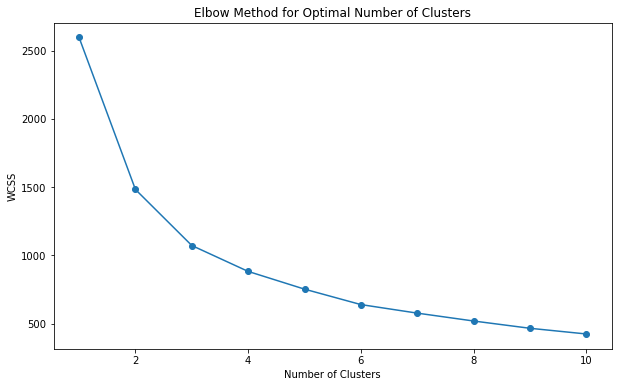

In [6]:
### determine the optimal number of clusters ### 

# Calculate the within cluster sum of squares (WCSS) for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(clustering_variables_scaled)
    wcss.append(kmeans.inertia_)

# plot using the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [7]:
### apply k means clustering ###

# fit k means with the optimal number of clusters
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
affordability['Cluster'] = kmeans.fit_predict(clustering_variables_scaled)

# inspect the cluster assignments
print(affordability[['RegionName', 'StateName', 'AffordabilityScore', 'Cluster']])

              RegionName StateName  AffordabilityScore  Cluster
0             Ada County        ID            0.761118        0
10          Adams County        CO            0.694324        2
20          Aiken County        SC            0.800075        0
30        Alachua County        FL            0.772945        0
40       Alamance County        NC            0.775355        0
...                  ...       ...                 ...      ...
3779  Yellowstone County        MT            0.751702        0
3789         Yolo County        CA            0.699006        2
3799         York County        ME            0.726930        2
3806         Yuba County        CA            0.698389        2
3809         Yuma County        AZ            0.704046        0

[649 rows x 4 columns]


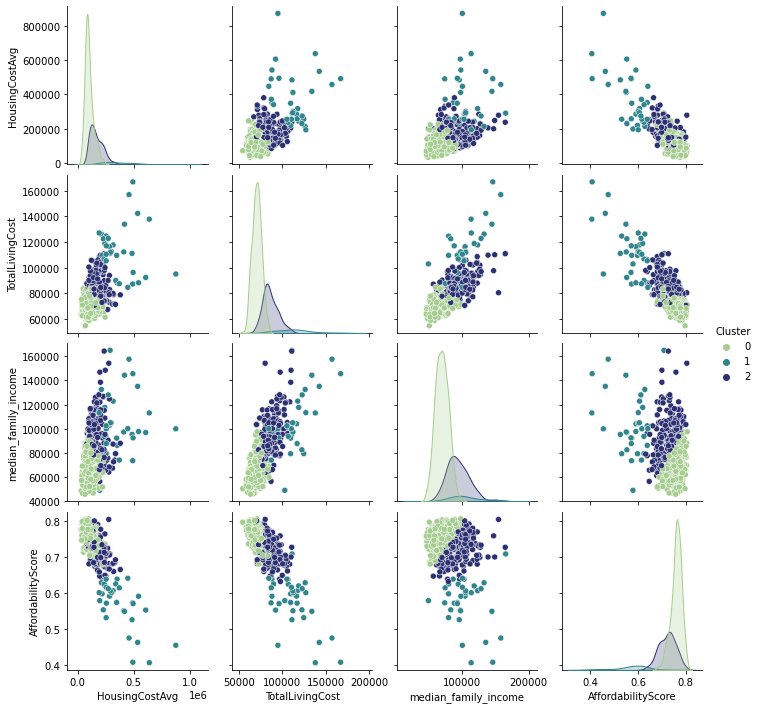

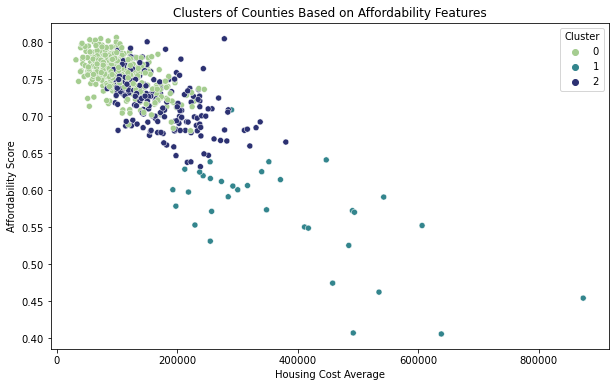

In [8]:
### visualize k means clustering results ###

# display the pairplot of the clusters
sns.pairplot(data=affordability, vars=['HousingCostAvg', 'TotalLivingCost', 'median_family_income', 'AffordabilityScore'], 
             hue='Cluster', palette='crest')
plt.show()

# display 2D scatterplot of two key features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=affordability, x='HousingCostAvg', y='AffordabilityScore', hue='Cluster', palette='crest')
plt.title('Clusters of Counties Based on Affordability Features')
plt.xlabel('Housing Cost Average')
plt.ylabel('Affordability Score')
plt.legend(title='Cluster')
plt.show()

Average Silhouette Score for 3 clusters: 0.41


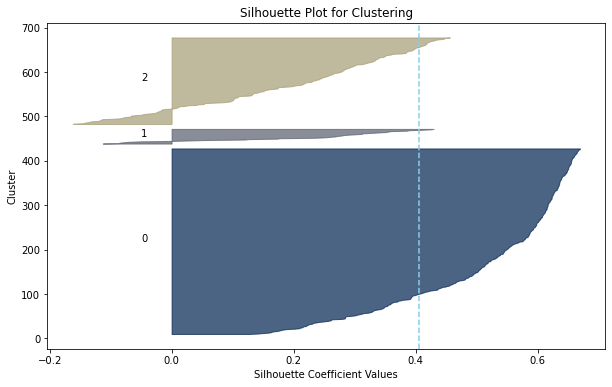

In [9]:
### use silhouette analysis to validate cluster quality ###

# compute the silhouette score
silhouette_avg = silhouette_score(clustering_variables_scaled, affordability['Cluster'])
print(f"Average Silhouette Score for {optimal_clusters} clusters: {silhouette_avg:.2f}")

# silhouette plot with a different colormap
sample_silhouette_values = silhouette_samples(clustering_variables_scaled, affordability['Cluster'])
plt.figure(figsize=(10, 6))
y_lower = 10

# select a different colormap
cmap = cm.cividis

for i in range(optimal_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[affordability['Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # use a color from the new colormap
    color = cmap(float(i) / optimal_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

# silhouette plot 
plt.axvline(x=silhouette_avg, color="skyblue", linestyle="--")
plt.title("Silhouette Plot for Clustering")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")
plt.show()

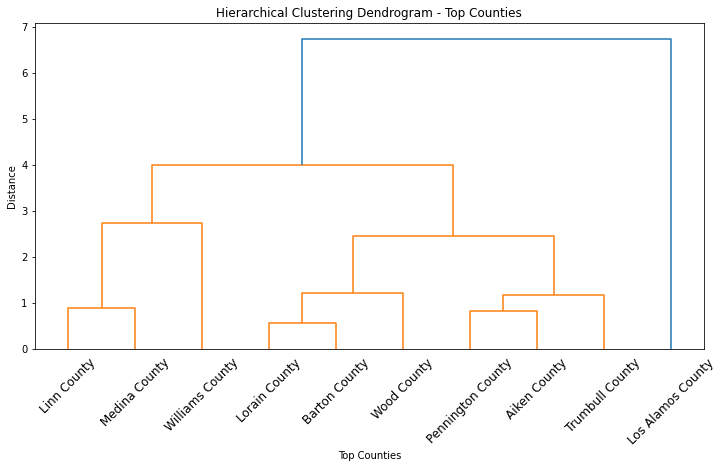

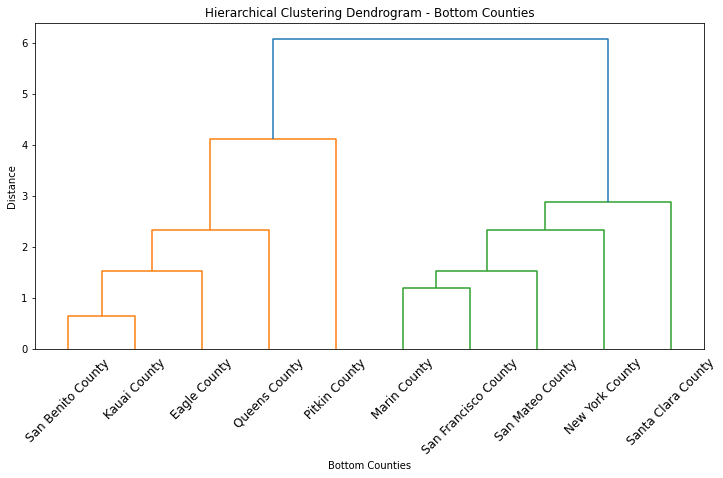

In [16]:
### comparing k means with hierarchical clustering ###

# fefine the number of counties to include in each group
num_counties = 10

# select top counties based on AffordabilityScore
top_counties = affordability.nlargest(num_counties, 'AffordabilityScore')

# select bottom counties based on AffordabilityScore
bottom_counties = affordability.nsmallest(num_counties, 'AffordabilityScore')

# standardize the data for both groups
scaler = StandardScaler()
top_clustering_variables_scaled = scaler.fit_transform(top_counties[clustering_variables.columns])
bottom_clustering_variables_scaled = scaler.fit_transform(bottom_counties[clustering_variables.columns])

# dendrogram for top counties
linked_top = linkage(top_clustering_variables_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(
    linked_top,
    orientation='top',
    labels=top_counties['RegionName'].values,
    distance_sort='descending',
    show_leaf_counts=False,
)
plt.title('Hierarchical Clustering Dendrogram - Top Counties')
plt.xlabel('Top Counties')
plt.ylabel('Distance')
plt.xticks(fontsize=12, rotation=45)
plt.show()

# dendrogram for bottom counties
linked_bottom = linkage(bottom_clustering_variables_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(
    linked_bottom,
    orientation='top',
    labels=bottom_counties['RegionName'].values,
    distance_sort='descending',
    show_leaf_counts=False,
)
plt.title('Hierarchical Clustering Dendrogram - Bottom Counties')
plt.xlabel('Bottom Counties')
plt.ylabel('Distance')
plt.xticks(fontsize=12, rotation=45)
plt.show()


In [11]:
### predicting cluster membership using supervised learning ###

# define the predictors and target
X = clustering_variables
y = affordability['Cluster']

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train the random forest classifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# evaluate the accuracy
y_pred = rf.predict(X_test)
print("Classification Report for Predicting Clusters:")
print(classification_report(y_test, y_pred))

# feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

Classification Report for Predicting Clusters:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       127
           1       0.67      1.00      0.80         6
           2       1.00      0.90      0.95        62

    accuracy                           0.97       195
   macro avg       0.88      0.97      0.91       195
weighted avg       0.97      0.97      0.97       195

Feature Importances:
                Feature  Importance
1       TotalLivingCost    0.402611
2  median_family_income    0.224901
3    AffordabilityScore    0.198250
0        HousingCostAvg    0.174238
